In [1]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, levene, f_oneway , chi2
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from scipy.stats import f
from scipy.stats import ttest_ind
from scipy.stats import kstest

/var/folders/kk/7w6727t942z6xwr_96jpcwtc0000gn/T/ipykernel_4193/866473043.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Exam Performance

In [2]:
data = pd.read_csv('exam_scores.csv')

##### Null Hypothesis (H0): Exam performance is not affected by type of schooling

##### Alternative Hypothesis (H1): Type of schooling affects exam performance

In [3]:
group_stats = {
    'Groups': ['Home', 'Boarding', 'Regular'],
    'Count': [len(data['Home']), len(data['Boarding']), len(data['Regular'])],
    'Sum': [data['Home'].sum(), data['Boarding'].sum(), data['Regular'].sum()],
    'Average': [data['Home'].mean(), data['Boarding'].mean(), data['Regular'].mean()],
    'Variance': [data['Home'].var(), data['Boarding'].var(), data['Regular'].var()]
}
group_stats_df = pd.DataFrame(group_stats)
print(group_stats_df)

     Groups  Count   Sum    Average    Variance
0      Home     15  1182  78.800000  141.171429
1  Boarding     15  1078  71.866667   73.980952
2   Regular     15  1263  84.200000   50.457143


## Check for Normality

In [4]:
shapiro_normality_tests = {}
for col in data.columns:
    stat, p = shapiro(data[col])
    shapiro_normality_tests[col] = {'Shapiro-Wilk Statistic': stat, 'p-value': p, 'Normality': p > 0.05}

lilliefors_normality_tests = {}
for col in data.keys():
    n = len(data[col])
    d, p = kstest(data[col], 'norm', args=(np.mean(data[col]), np.std(data[col], ddof=1)))
    lilliefors_normality_tests[col] = {'Kolmogorov-Smirnov Statistic': d, 'p-value': p, 'Normality': p > 0.05}

print("Shapiro Normality Tests:")
print(pd.DataFrame(shapiro_normality_tests))
print("\n")
print("Kolmogorov-Smirnov Tests with Lilliefors Significance Correction:")
print(pd.DataFrame(lilliefors_normality_tests))

Shapiro Normality Tests:
                            Home  Boarding   Regular
Shapiro-Wilk Statistic  0.905427  0.969238   0.97489
p-value                 0.115225  0.846616  0.922709
Normality                   True      True      True


Kolmogorov-Smirnov Tests with Lilliefors Significance Correction:
                                  Home  Boarding   Regular
Kolmogorov-Smirnov Statistic  0.154949  0.114252  0.099591
p-value                       0.812204  0.976888  0.994779
Normality                         True      True      True


### Check homogeneity of variances (different participants in different groups, Factorial ANOVA)

In [5]:
levene_mean = levene(data['Home'], data['Boarding'], data['Regular'], center='mean')
levene_median = levene(data['Home'], data['Boarding'], data['Regular'], center='median')
levene_trimmed_mean = levene(data['Home'], data['Boarding'], data['Regular'], center='trimmed')
print("\nHomogeneity of Variances Test:")
levene_test = pd.DataFrame({
    'Center': ['Mean', 'Median', 'Trimmed Mean'],
    'Test-Statistic': [levene_mean.statistic, levene_median.statistic, levene_trimmed_mean.statistic],
    'p-value': [levene_mean.pvalue, levene_median.pvalue, levene_trimmed_mean.pvalue]
})
print(levene_test)
if levene_mean.pvalue > 0.05:
    print("Variance is homogenous based on mean")
elif levene_median.pvalue > 0.05:
    print("Variance is homogenous based on median")
elif levene_trimmed_mean.pvalue > 0.05:
    print("Variance is homogenous based on trimmed mean")
else:
    print("Variance is not homogenous")


if levene_mean.pvalue > 0.05:
    print("\nOne-Way ANOVA Test is chosen")
else:
    print("\nRobust Welch's ANOVA Test is chosen")


Homogeneity of Variances Test:
         Center  Test-Statistic   p-value
0          Mean        1.674937  0.199589
1        Median        1.647691  0.204693
2  Trimmed Mean        1.674937  0.199589
Variance is homogenous based on mean

One-Way ANOVA Test is chosen


In [6]:
Home = data['Home']
Boarding = data['Boarding']
Regular = data['Regular']

k = 3
N = len(Home) + len(Boarding) + len(Regular)
group_means = [np.mean(Home), np.mean(Boarding), np.mean(Regular)]
grand_mean = np.mean([np.mean(Home), np.mean(Boarding), np.mean(Regular)])
SSb = sum([len(Home) * (group_means[0] - grand_mean) ** 2,
           len(Boarding) * (group_means[1] - grand_mean) ** 2,
           len(Regular) * (group_means[2] - grand_mean) ** 2])
dfb = k-1
MSb = SSb / dfb
SSw = sum([(x - group_means[i]) ** 2 for i, data in enumerate([Home, Boarding, Regular]) for x in data])
dfw = N-k
MSw = SSw / dfw
F_value = MSb / MSw
alpha = 0.05
F_crit = f.ppf(1 - alpha, dfb, dfw)
p_value = 1-f.cdf(F_value, dfb, dfw)


anova_table = [
    ["Between Groups", f"{SSb:.6f}", dfb, f"{MSb:.6f}", f"{F_value:.6f}",f"{p_value:.6f}" ,f"{F_crit:.6f}"],
    ["Within Groups", f"{SSw:.6f}", dfw, f"{MSw:.6f}"],
    ["Total", f"{SSb+SSw:.6f}", dfb+dfw]
]

print("ANOVA Table")
print(tabulate(anova_table, headers=["Source of Variation", "SS", "df", "MS", "F", "p-value","F crit"], tablefmt="pretty"))

ANOVA Table
+---------------------+-------------+----+------------+----------+----------+----------+
| Source of Variation |     SS      | df |     MS     |    F     | p-value  |  F crit  |
+---------------------+-------------+----+------------+----------+----------+----------+
|   Between Groups    | 1146.711111 | 2  | 573.355556 | 6.475922 | 0.003537 | 3.219942 |
|    Within Groups    | 3718.533333 | 42 | 88.536508  |          |          |          |
|        Total        | 4865.244444 | 44 |            |          |          |          |
+---------------------+-------------+----+------------+----------+----------+----------+


In [7]:
anova_result = f_oneway(data['Home'], data['Boarding'], data['Regular'])
print("\nOne-way ANOVA Test:")
print(f"F-statistic: {anova_result.statistic}")
print(f"p-value: {anova_result.pvalue}")

if anova_result.pvalue < 0.05:
    print("\nSince p-value < 0.05, there are significant differences between groups. Using a one way ANOVA we observed that the schooling method has a significant effect on exam  performance")
else:
    print("\nNo significant differences between groups.")


One-way ANOVA Test:
F-statistic: 6.475922406683641
p-value: 0.003536773789503349

Since p-value < 0.05, there are significant differences between groups. Using a one way ANOVA we observed that the schooling method has a significant effect on exam  performance


In [8]:
Effect_size = SSb / (SSb + SSw)
print(f"Effect Size: {Effect_size:.6f}")
print(f"Type of schooling explains {Effect_size*100:.2f}% of the variance in exam performance")

Effect Size: 0.235694
Type of schooling explains 23.57% of the variance in exam performance


##### We know there is difference between the groups,but which groups perform better or worse?

>*  Planned comparison (contrast) – prior to experiment (based on the literature)
>*  Regular schooling > (boarding or home school)
>*  Regular schooling – Control condition
>*  Boarding school – Experimental condition 1
>* Home school – Experimental condition 2
>* But as the no. of planned comparisons increase (>2 comparisons), the alpha level has to adjusted, again to avoid Type I error. This is done by dividing the alpha level by the no. of comparisons. This is called Bonferroni correction.

### Post-hoc Bonferroni and Tukeýs HSD test

In [9]:
t_statistic_home_boarding, p_value_home_boarding = ttest_ind(Home, Boarding)
t_statistic_boarding_regular, p_value_boarding_regular = ttest_ind(Boarding, Regular)
t_statistic_regular_home, p_value_regular_home = ttest_ind(Regular, Home)

alpha = 0.05
alpha_corrected = alpha / 3 

print("alpha corrected: ", alpha_corrected)

p_value_home_boarding_corrected = p_value_home_boarding * 3
p_value_boarding_regular_corrected = p_value_boarding_regular * 3
p_value_regular_home_corrected = p_value_regular_home * 3

table_data = [
    ['Groupwise comparisons', 'T-test p-value', 'Bonferroni-corrected p-value'],
    ['Home vs Boarding', p_value_home_boarding, p_value_home_boarding_corrected],
    ['Boarding vs Regular', p_value_boarding_regular, p_value_boarding_regular_corrected],
    ['Regular vs Home', p_value_regular_home, p_value_regular_home_corrected]
]
print(tabulate(table_data, headers="firstrow", tablefmt="grid"))

alpha corrected:  0.016666666666666666
+-------------------------+------------------+--------------------------------+
| Groupwise comparisons   |   T-test p-value |   Bonferroni-corrected p-value |
+=========================+==================+================================+
| Home vs Boarding        |       0.07781    |                    0.23343     |
+-------------------------+------------------+--------------------------------+
| Boarding vs Regular     |       0.00019644 |                    0.000589321 |
+-------------------------+------------------+--------------------------------+
| Regular vs Home         |       0.142042   |                    0.426125    |
+-------------------------+------------------+--------------------------------+


In [10]:
if anova_result.pvalue < 0.05:
    data_melted = pd.melt(data)
    posthoc = pairwise_tukeyhsd(data_melted['value'], data_melted['variable'], alpha=0.05)
    print(posthoc)
    print(posthoc.q_crit) 
    HSD = posthoc.q_crit*np.sqrt(MSw / len(data))
    print(f"HSD: {HSD:.6f}")
    print(f"The mean difference between any two samples must be more than {HSD:.6f} at alpha = 0.05 for the difference to be statistically significant")

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2 meandiff p-adj   lower   upper  reject
-------------------------------------------------------
Boarding    Home   6.9333 0.1204  -1.414 15.2806  False
Boarding Regular  12.3333 0.0024   3.986 20.6806   True
    Home Regular      5.4  0.269 -2.9473 13.7473  False
-------------------------------------------------------
3.4358230206770175
HSD: 8.347306
The mean difference between any two samples must be more than 8.347306 at alpha = 0.05 for the difference to be statistically significant


Using Bonferroni post-hoc test, we found that regular school resulted in better exam performance than boarding school (p<.001). There was no significant difference between the other groups

In [11]:
effect_size = anova_result.statistic / (anova_result.statistic + (len(data) - 1))
print("\nEffect Size (Eta-squared):", effect_size)


Effect Size (Eta-squared): 0.3162701185354075


# Plot Analyzed Data

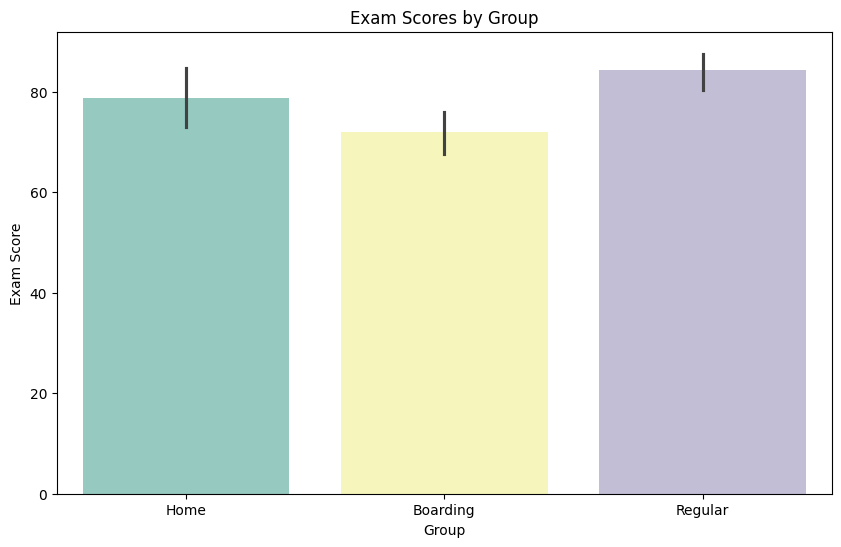

Error bars denote confidence intervals (CI) of 95%


In [12]:
data_melted = pd.melt(data)
plt.figure(figsize=(10, 6))
sns.barplot(x='variable', y='value', data=data_melted, errorbar=('ci', 95), hue='variable', palette="Set3")
plt.title('Exam Scores by Group')
plt.xlabel('Group')
plt.ylabel('Exam Score')
plt.show()
print("Error bars denote confidence intervals (CI) of 95%")

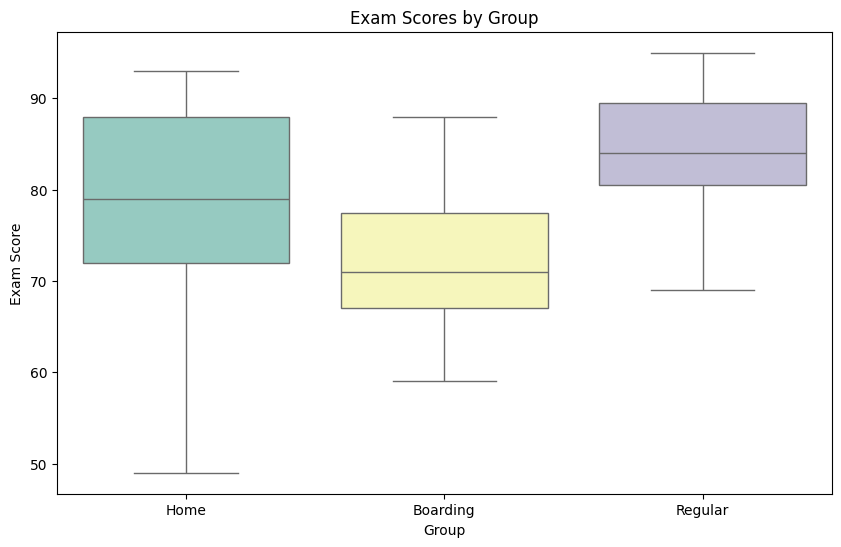

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='variable', y='value', hue='variable', data=data.melt(), palette="Set3", legend=False)
plt.title('Exam Scores by Group')
plt.xlabel('Group')
plt.ylabel('Exam Score')
plt.show()